In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
df = pd.read_csv('data/nhanes_2015_2016.csv')
df.SMQ020.value_counts()

2    3406
1    2319
9       8
7       2
Name: SMQ020, dtype: int64

In [3]:
df['SMQ020x'] = df.SMQ020.replace({1:"Yes",2:"No",7:np.nan,9:np.nan})
df.SMQ020x.value_counts()

No     3406
Yes    2319
Name: SMQ020x, dtype: int64

In [4]:
df["RIAGENDRx"] = df.RIAGENDR.replace({1: "Male", 2: "Female"})
ctab = pd.crosstab(index=df['RIAGENDRx'],columns=df['SMQ020x'])

In [5]:
# lets compute the stats for female smokers
# proportion of females that are smokers
df['SMQ020xx'] = df['SMQ020x'].replace({"Yes":1,"No":0})
dx = df.groupby(['RIAGENDRx']).agg({'SMQ020xx':[np.mean,'count']})
dx

SMQ020xx      
               mean count
RIAGENDRx                
Female     0.304845  2972
Male       0.513258  2753

In [6]:
df = df[~pd.isnull(df["SMQ020x"])]
df["agegrp"] = pd.cut(df.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
dz = df.groupby(['agegrp','RIAGENDRx']).agg({'SMQ020x':[lambda x: np.mean(x=='Yes')]})
dz.columns = dz.columns.droplevel(level=0)
dz = dz.rename(columns={'<lambda>':'proportions'})
dz1 = dz.unstack()
dz1.columns = dz1.columns.droplevel(level=0)
dz1

RIAGENDRx,Female,Male
agegrp,,
"(18, 30]",0.226974,0.349265
"(30, 40]",0.287526,0.503282
"(40, 50]",0.268924,0.448878
"(50, 60]",0.422175,0.572687
"(60, 70]",0.374150,0.655963
"(70, 80]",0.325183,0.655779


In [7]:
dc = df.groupby(['agegrp','RIAGENDRx']).agg({'SMQ020x':'count'})
dc = dc.unstack()
dc.columns = dc.columns.droplevel(level=0)
dc

RIAGENDRx,Female,Male
agegrp,,
"(18, 30]",608,544
"(30, 40]",473,457
"(40, 50]",502,401
"(50, 60]",469,454
"(60, 70]",441,436
"(70, 80]",409,398


In [8]:
dstd = np.sqrt(dz1*(1-dz1)/dc)
dstd

RIAGENDRx,Female,Male
agegrp,,
"(18, 30]",0.016988,0.020440
"(30, 40]",0.020811,0.023389
"(40, 50]",0.019790,0.024838
"(50, 60]",0.022806,0.023217
"(60, 70]",0.023043,0.022751
"(70, 80]",0.023163,0.023815


In [9]:
dstd_diff = np.sqrt(dstd.Female**2 + dstd.Male**2)
dstd_diff

agegrp
(18, 30]    0.026578
(30, 40]    0.031307
(40, 50]    0.031758
(50, 60]    0.032545
(60, 70]    0.032382
(70, 80]    0.033222
dtype: float64

In [18]:
# Calculate the mean, SD, and sample size for BMI within age/gender groups
da = df
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
pr = da.groupby(["agegrp", "RIAGENDRx"]).agg({"BMXBMI": [np.mean, np.std, np.size]}).unstack()

In [19]:
pr

BMXBMI                                             
                mean                  std             size       
RIAGENDRx     Female       Male    Female      Male Female   Male
agegrp                                                           
(18, 30]   28.126910  27.391822  7.751977  6.649440  608.0  544.0
(30, 40]   30.347009  29.631929  8.311542  6.615806  473.0  457.0
(40, 50]   31.160643  29.724623  8.076195  6.407076  502.0  401.0
(50, 60]   30.752473  29.231486  7.581679  5.914373  469.0  454.0
(60, 70]   31.074828  29.368471  7.604514  5.919531  441.0  436.0
(70, 80]   29.121642  27.931865  6.283978  4.985881  409.0  398.0

In [48]:
pr["BMXBMI","sem","Female"] = pr["BMXBMI","std","Female"]/np.sqrt(pr["BMXBMI","size","Female"])
pr["BMXBMI","sem","Male"] = pr["BMXBMI","std","Male"]/np.sqrt(pr["BMXBMI","size","Male"])
pr["BMXBMI","sem_diff",""] = np.sqrt(pr["BMXBMI","sem","Female"]**2 + pr["BMXBMI","sem","Male"]**2)
pr["BMXBMI","mean_diff",""] = pr["BMXBMI","mean","Female"] - pr["BMXBMI","mean","Male"]
pr["BMXBMI","lcb",""] = pr["BMXBMI","mean_diff",""] - 1.96*pr["BMXBMI","sem_diff",""]
pr["BMXBMI","ucb",""] = pr["BMXBMI","mean_diff",""] + 1.96*pr["BMXBMI","sem_diff",""]

In [49]:
print(pr.index.size)
pr

6


BMXBMI               ...                       
                mean               ...          lcb       ucb
RIAGENDRx     Female       Male    ...                       
agegrp                             ...                       
(18, 30]   28.126910  27.391822    ...    -0.096735  1.566912
(30, 40]   30.347009  29.631929    ...    -0.248763  1.678922
(40, 50]   31.160643  29.724623    ...     0.491347  2.380692
(50, 60]   30.752473  29.231486    ...     0.645303  2.396672
(60, 70]   31.074828  29.368471    ...     0.804972  2.607744
(70, 80]   29.121642  27.931865    ...     0.408210  1.971343

[6 rows x 12 columns]

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

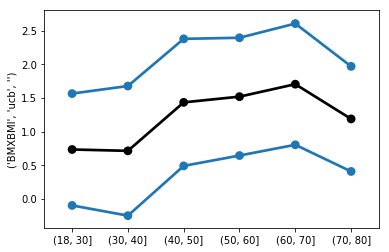

In [51]:
x = np.arange(pr.index.size)
pp = sns.pointplot(x=x,y=pr["BMXBMI","mean_diff",""],color='black')
sns.pointplot(x=x,y=pr["BMXBMI","lcb",""])
sns.pointplot(x=x,y=pr["BMXBMI","ucb",""])

pp.set_xticklabels(pr.index);

In [59]:
dx = da.loc[da.RIAGENDRx=="Female",['BMXBMI']].dropna()
all_cis = []
for n in 100,200,300,400,500:
    cis_sample = []
    for _ in range(500):
        samples = dx.sample(n)
        cis = sm.stats.DescrStatsW(samples.BMXBMI).zconfint_mean()
        cis_sample.append(cis)
    cis_sample = np.asarray(cis_sample)
    print(n,cis_sample[:,1].mean() - cis_sample[:,0].mean())
    all_cis.append(cis_sample)

100 3.0273753858256818
200 2.137652666009302
300 1.7501681847972428
400 1.521446923987007
500 1.3579298155351154


In [54]:
dx = da.loc[da.RIAGENDRx=="Female",['BMXBMI']].dropna()
sm.stats.DescrStatsW(dx.BMXBMI).zconfint_mean()

(29.663239914863667, 30.223902942279196)

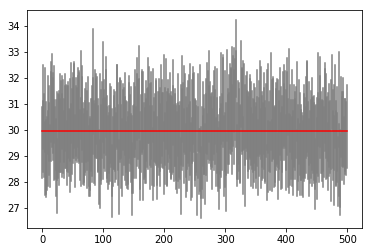

In [70]:
samples = np.array(all_cis)[0]
for index,value in enumerate(samples):
    plt.plot([index,index],value,color='gray')
mean = dx.BMXBMI.mean()
plt.plot(np.arange(500),[mean]*500,color='red')